In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
!curl -L https://github.com/NikolausHouben/HAB_Strom/blob/d0ac42bb653de446ab88d503a90433519dff6bfb/Daten/data_1.csv\?raw\=true -o data_1.csv
df_1 = pd.read_csv("data_1.csv", index_col = 0, parse_dates = True).resample("60T").mean()

!curl -L https://github.com/NikolausHouben/HAB_Strom/blob/d0ac42bb653de446ab88d503a90433519dff6bfb/Daten/data_2.csv\?raw\=true -o data_2.csv
df_2 = pd.read_csv("data_2.csv", index_col = 0, parse_dates = True).resample("60T").mean()

## Feature Engineering

### Skalierung der Zeitreihe

In [ ]:
df_1.head()

In [ ]:
scaler = MinMaxScaler()
df_1[df_1.columns] = scaler.fit_transform(df_1[df_1.columns])
df_1.head()

### Autokorrelation: Lags

In [ ]:
def create_lag_variables(
    df, number_of_timesteps_in_season, number_of_lags=3, keep_first_col=True
):

    """
    Create a number of lag features for a dataframe with one column:
    'number_of_timesteps_in_season': how many timesteps make up one season (the interval between lag features)
    'number_of_lags': how many lag features
    """

    if number_of_timesteps_in_season <= 0 or type(number_of_timesteps_in_season) != int:
        raise ValueError(
            "Input a positive integer for 'number_of_timesteps_in_season.'"
        )

    df_appended = df.copy()
    for i in range(1, number_of_lags + 1):
        lagged = df_appended.iloc[:, :1].shift((i) * number_of_timesteps_in_season)
        lagged.columns = [
            df_appended.columns[0]
            + "_lag_season_"
            + str(number_of_timesteps_in_season)
            + "-"
            + str(i)
        ]
        df_appended = pd.merge(
            df_appended, lagged, left_index=True, right_index=True, how="left"
        )

    if keep_first_col:
        df_return = pd.concat(
            [df.iloc[:, :1], df_appended.iloc[:, 1:]], axis=1
        ).dropna()
    else:
        df_return = df_appended.iloc[:, 1:]

    return df_return


def create_lag_features(df, lag_dict):

    df_ = create_lag_variables(
        df,
        lag_dict["autoregressive"][1],
        lag_dict["autoregressive"][0],
    )

    df__ = create_lag_variables(
        df,
        lag_dict["seasonal"][1],
        lag_dict["seasonal"][0],
        False,
    )

    df_return = pd.concat([df_, df__], axis=1)

    return df_return


In [ ]:
lag_dict = {"autoregressive": (48,1), "seasonal": (3,7*24)} # (anzahl_der_lags, zeitschritt eines lags), ...

df_1_lags = create_lag_features(df_1, lag_dict).dropna()

df_1_lags.head()

### Periodizität: Datetime Features

In [ ]:
def get_timestep_interval(df):
    """Infers the interval of the DateTimeIndex of a pd.DataFrame in seconds."""
    timesteplens = []
    for i in range((int(df.shape[0] * 0.5))):
        diff = df.index[i + 1] - df.index[i]
        timesteplen = int(diff.total_seconds())
        timesteplens.append(timesteplen)
    timesteplen_final = int(stats.mode(np.array(timesteplens)).mode[0])

    return timesteplen_final

def timestep_of_day_maker(df):

    df_ = df.copy()
    timesteplen = get_timestep_interval(df_) / 60
    interval = int(timesteplen)
    if timesteplen < 60 * 24:
        df_["timestep_of_the_day"] = df_.index.hour * (
            60 / interval
        ) + df_.index.minute / (interval)

    else:
        df_["timestep_of_the_day"] = 1
    df_["weekday"] = df_.index.dayofweek + 1
    df_["month"] = df_.index.month
    return df_


def trig_datetime_encoder(df, cycle_1, cycle_2=None):

    """
    Encoding datetime features into trigonometric features (better when model should respect periodicity in data).
    Two cycles of the following are allowed: "weekday, timestep_of_the_day, month".
    The second cycle is optional.
    'timesteplen': minutes from one timestep to the next
    """
    df_ = timestep_of_day_maker(df)
    periods_dict = {
        "weekday": 7,
        "timestep_of_the_day": df_["timestep_of_the_day"].max(),
        "month": 12,
        None: 1,
    }

    # input checks
    if cycle_1 not in list(periods_dict.keys()):
        raise ValueError(
            "Make sure your cycles are in ['weekday', 'timestep_of_the_day', 'month']."
        )
    if cycle_2 not in list(periods_dict.keys()):
        raise ValueError(
            "Make sure your cycles are in ['weekday', 'timestep_of_the_day', 'month']."
        )

    # column creation
    df_[cycle_1 + "_sin"] = df_[cycle_1].apply(
        lambda x: np.sin(x / periods_dict[cycle_1] * 2 * np.pi)
    )
    df_[cycle_1 + "_cos"] = df_[cycle_1].apply(
        lambda x: np.cos(x / periods_dict[cycle_1] * 2 * np.pi)
    )
    if cycle_2 != None:
        df_[cycle_2 + "_sin"] = df_[cycle_2].apply(
            lambda x: np.sin(x / periods_dict[cycle_2] * 2 * np.pi)
        )
        df_[cycle_2 + "_cos"] = df_[cycle_2].apply(
            lambda x: np.cos(x / periods_dict[cycle_2] * 2 * np.pi)
        )

    df_ = df_.drop(["weekday", "timestep_of_the_day", "month"], axis=1)
    return df_

In [ ]:
df_1_trig = trig_datetime_encoder(df_1, "timestep_of_the_day", "weekday")
df_1_trig.head()

In [ ]:
px.line(df_1_trig.iloc[:192,1:])

In [ ]:
df_1_features = pd.merge(df_1_lags, df_1_trig.iloc[:,1:], left_index = True, right_index= True)

df_1_features.head()

### Linear Regression

### Sklearn (Normal Equation) – Die Parameter der Linearen Regression können durch ein Lineares Gleichungssystem gelöst werden. Die Sklearn-Implementierung verwendet diese herangehensweise. Diese ist schneller als die iterative "Stochastic Gradient Descent" Methode, welche im Anschluss vorgestellt werd.

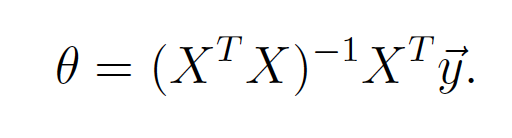




In [ ]:
# Aufgabe 1: Teile den Datensatz (df_1) in ein Trainings und Test Set mit einem Verhältnis 80/20 auf.

# CODE

In [ ]:
# Aufgabe 2: Importiere das Lineare Regressions Model von Sklearn und rufe .fit auf, um es zu trainieren.

# CODE...

### One-Step Regression

In [ ]:
predictions = model.predict(X_test)

y_test["predictions"] = predictions

In [ ]:
px.line(y_test)

In [ ]:
mean_squared_error(scaler.inverse_transform(y_test["y_1"].values.reshape(-1,1)),scaler.inverse_transform(y_test["predictions"].values.reshape(-1,1)), squared = False)

### Multi-Step Ahead Regression

Es gibt zwei unterschiedliche Methoden um mehrere Zeitschritte voraus (z.B. Day-ahead) zu prognostizieren: Rekursiv oder Direkt

* Der Vorteil an der Direkten Methode ist, dass es keine Fehlerfortplanzung gibt.

* Der Nachteil an der Direkten Methode ist, dass man ein Modell pro Zeitschritt trainieren will (für Day-Ahead in 15 Minuten sind das 96 Modelle)

Wir verwenden nun die Rekursive Methode, die auch in **Neural Networks** verwendet wird:

In [ ]:
def n_step_recursive_regression(
    df_features, model, scaler_target, n_ahead
):

    y_predictions = df_features.iloc[:, :1].copy()
    X_features = df_features.iloc[:, 1:].copy()
    number_of_regression_steps = n_ahead

    for i in range(X_features.shape[0]):

        # CODE:

    predictions = scaler_target.inverse_transform(y_predictions)

    return predictions

In [ ]:
df_compares = []
n_ahead = 24
for start in range(0,24*7*3, n_ahead):
  preds = n_step_recursive_regression(test.iloc[start:start+n_ahead,:], model, scaler, n_ahead).squeeze()
  gt = scaler.inverse_transform(test.iloc[start:start+n_ahead,:1]).squeeze()
  df_compare = pd.DataFrame({"Ground_Truth": gt, "Predictions": preds}, index = test.iloc[start:start+n_ahead,:1].index)
  df_compares.append(df_compare)




In [ ]:
df_compare_show = pd.concat(df_compares, axis = 0).sort_index()

In [ ]:
px.line(df_compare_show)

In [ ]:
mean_squared_error(df_compare_show.iloc[:,:1],df_compare_show.iloc[:,1:], squared = False)

### Wieso so viel ungenauer?
